In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [3]:
# Load data
file_2022 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-22_12-00_AM_1_Year_1732084536_v2.xlsx')
file_2023 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-23_12-00_AM_1_Year_1732084578_v2.xlsx')
file_2024 = pd.read_excel('Region_4A_DA_MORONG_RIZAL_1-1-24_12-00_AM_1_Year_1732084607_v2.xlsx')

# Select necessary columns
cols_needed = ['Date & Time', 'Rain - mm', 'Rain Rate - mm/h']
df_2022 = file_2022[cols_needed]
df_2023 = file_2023[cols_needed]
df_2024 = file_2024[cols_needed]
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

In [4]:
# Prepare the data
combined_df['Date & Time'] = pd.to_datetime(combined_df['Date & Time'], format='%m/%d/%y %I:%M %p')
combined_df = combined_df.sort_values(by='Date & Time')
combined_df['Rain - mm'] = combined_df['Rain - mm'].fillna(0)
combined_df['Rain Rate - mm/h'] = combined_df['Rain Rate - mm/h'].fillna(0)

# Resample data
resampled_15min = combined_df.set_index('Date & Time').resample('15min').mean()
resampled_1hr = combined_df.set_index('Date & Time').resample('1h').mean()
resampled_15min.ffill(inplace=True)
resampled_1hr.ffill(inplace=True)

In [5]:
# Add time-related features
for df in [resampled_15min, resampled_1hr]:
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek


In [11]:
# Normalize data
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

def normalize_data(data):
    normalized_data = data.copy()
    features = ['Rain - mm', 'Rain Rate - mm/h', 'hour', 'day_of_week']
    normalized_data[features] = scaler_features.fit_transform(data[features])
    normalized_data['Rain Rate - mm/h'] = scaler_labels.fit_transform(data[['Rain Rate - mm/h']])
    return normalized_data

normalized_15min = normalize_data(resampled_15min)
normalized_1hr = normalize_data(resampled_1hr)
# Save scalers
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_labels, 'scaler_labels.pkl')

['scaler_labels.pkl']

In [13]:
# Create sequences for LSTM
def create_lstm_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length, :].values
        label = data.iloc[i + sequence_length]['Rain Rate - mm/h']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 30
X_15min, y_15min = create_lstm_sequences(normalized_15min, sequence_length)
X_1hr, y_1hr = create_lstm_sequences(normalized_1hr, sequence_length)

In [14]:
# Build LSTM model with L2 regularization, Dropout, and BatchNormalization
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(l2_regularization)),
        Dropout(dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units // 2, return_sequences=False, kernel_regularizer=l2(l2_regularization)),
        Dropout(dropout_rate),
        BatchNormalization(),
        Dense(1)  # No activation function for regression tasks
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

Epoch 1/20


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


538/538 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 1.5131 - val_loss: 0.3815
Epoch 2/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.4120 - val_loss: 0.1664
Epoch 3/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2237 - val_loss: 0.0855
Epoch 4/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0791 - val_loss: 0.0556
Epoch 5/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0744 - val_loss: 0.0410
Epoch 6/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0813 - val_loss: 0.0335
Epoch 7/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.2303 - val_loss: 0.0290
Epoch 8/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1859 - val_loss: 0.0297
Epoch 9/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0703 - val_loss: 0.0397
Epoch 10/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0690 - val_loss: 0.0363
Epoch 11/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2037 - val_loss: 0.0286
Epoch 12/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 9s 16m

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.9373 - val_loss: 0.1088
Epoch 2/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.1639 - val_loss: 0.0396
Epoch 3/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0695 - val_loss: 0.0316
Epoch 4/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0759 - val_loss: 0.0286
Epoch 5/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0371 - val_loss: 0.0321
Epoch 6/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0255 - val_loss: 0.0324
Epoch 7/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.2728 - val_loss: 0.0284
Epoch 8/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0662 - val_loss: 0.0283
Epoch 9/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0564 - val_loss: 0.0299
Epoch 10/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0566 - val_loss: 0.0274
Epoch 11/20
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0747 - val_loss: 0.0246
Epoch 12/20
1076/10

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.6692 - val_loss: 0.0653
Epoch 2/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0476 - val_loss: 0.0471
Epoch 3/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.0645 - val_loss: 0.0407
Epoch 4/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0368 - val_loss: 0.0458
Epoch 5/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0283 - val_loss: 0.0480
Epoch 6/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0760 - val_loss: 0.0392
Epoch 7/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.1054 - val_loss: 0.0380
Epoch 8/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0898 - val_loss: 0.0371
Epoch 9/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.1404 - val_loss: 0.0374
Epoch 10/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0812 - val_loss: 0.0384
Epoch 11/20
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0282 - val_loss: 0.0410
Epoch 12/20
1614/16

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.6810 - val_loss: 1.3089
Epoch 2/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 0.0475 - val_loss: 1.1671
Epoch 3/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - loss: 0.0596 - val_loss: 0.5652
Epoch 4/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 0.0964 - val_loss: 0.5831
Epoch 5/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 0.1103 - val_loss: 0.4115
Epoch 6/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 0.0311 - val_loss: 0.7694
Epoch 7/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - loss: 0.1091 - val_loss: 0.7169
Epoch 8/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - loss: 0.0504 - val_loss: 0.5550
Epoch 9/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.0448 - val_loss: 0.6591
Epoch 10/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.0333 - val_loss: 0.4092
Epoch 11/20
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - loss: 0.0401 - val_loss: 0.8648
Epoch 12/20
2152/21

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 63s 20ms/step - loss: 0.6213 - val_loss: 3.0323
Epoch 2/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - loss: 0.1326 - val_loss: 2.9799
Epoch 3/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.1321 - val_loss: 3.0180
Epoch 4/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.1350 - val_loss: 2.8272
Epoch 5/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 0.1206 - val_loss: 2.9253
Epoch 6/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - loss: 0.1088 - val_loss: 2.8894
Epoch 7/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step - loss: 0.1114 - val_loss: 2.4517
Epoch 8/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 51s 19ms/step - loss: 0.1093 - val_loss: 2.6866
Epoch 9/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 0.1177 - val_loss: 2.5022
Epoch 10/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - loss: 0.1062 - val_loss: 3.0843
Epoch 11/20
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - loss: 0.1241 - val_loss: 2.9645
Epoch 12

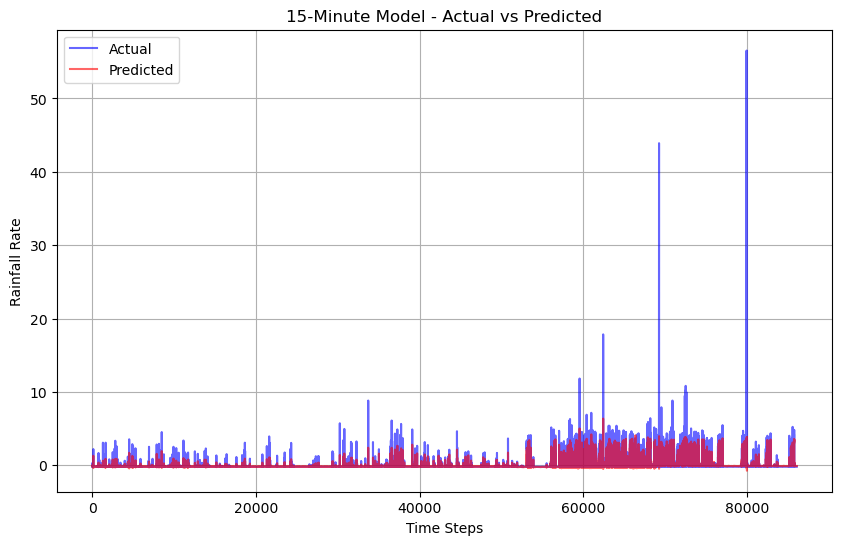

Epoch 1/20


C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 1.6348 - val_loss: 0.7169
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0274 - val_loss: 0.5301
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.7381 - val_loss: 0.3920
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.4815 - val_loss: 0.2899
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.4242 - val_loss: 0.2177
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2712 - val_loss: 0.1652
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1921 - val_loss: 0.1280
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1508 - val_loss: 0.1013
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1364 - val_loss: 0.0816
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1303 - val_loss: 0.0669
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0876 - val_loss: 0.0564
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/st

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 1.2049 - val_loss: 0.4116
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.4552 - val_loss: 0.1856
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.2074 - val_loss: 0.0913
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0989 - val_loss: 0.0515
Epoch 5/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0594 - val_loss: 0.0339
Epoch 6/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0419 - val_loss: 0.0261
Epoch 7/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 8/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0315 - val_loss: 0.0203
Epoch 9/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0547 - val_loss: 0.0197
Epoch 10/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0161 - val_loss: 0.0203
Epoch 11/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0394 - val_loss: 0.0189
Epoch 12/20
269/269 ━━━━━━━━━━━━━━━━━━━━

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


404/404 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 1.2795 - val_loss: 0.3592
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.3844 - val_loss: 0.1548
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1421 - val_loss: 0.0846
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1004 - val_loss: 0.0568
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0393 - val_loss: 0.0446
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0337 - val_loss: 0.0385
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0314 - val_loss: 0.0353
Epoch 8/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0335 - val_loss: 0.0343
Epoch 9/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0249 - val_loss: 0.0330
Epoch 10/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0177 - val_loss: 0.0327
Epoch 11/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0371 - val_loss: 0.0326
Epoch 12/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/st

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 1.1892 - val_loss: 1.8027
Epoch 2/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2821 - val_loss: 1.4940
Epoch 3/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1259 - val_loss: 1.5264
Epoch 4/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0793 - val_loss: 1.5536
Epoch 5/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0377 - val_loss: 1.5399
Epoch 6/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0427 - val_loss: 1.5093
Epoch 7/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0190 - val_loss: 1.2513
Epoch 8/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0244 - val_loss: 1.2038
Epoch 9/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0237 - val_loss: 1.4261
Epoch 10/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0236 - val_loss: 1.0664
Epoch 11/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0207 - val_loss: 1.2912
Epoch 12/20
538/538 ━━━━━━━━━━

C:\Users\nikki\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


672/672 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 1.1582 - val_loss: 3.4602
Epoch 2/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.2958 - val_loss: 3.1711
Epoch 3/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.1601 - val_loss: 3.0742
Epoch 4/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1281 - val_loss: 3.0970
Epoch 5/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1267 - val_loss: 3.0601
Epoch 6/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.1136 - val_loss: 3.0877
Epoch 7/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1060 - val_loss: 3.1321
Epoch 8/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0982 - val_loss: 3.0959
Epoch 9/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1029 - val_loss: 3.0719
Epoch 10/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.1320 - val_loss: 3.0514
Epoch 11/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.1004 - val_loss: 3.1075
Epoch 12/20
672/672 ━━━━━━━━━━━━━━━━━━━━ 

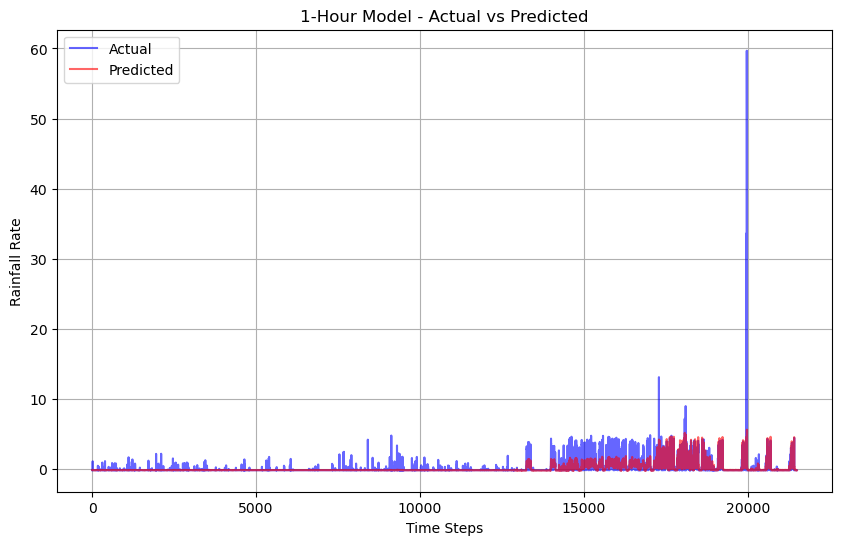

In [15]:
# Train and evaluate function
def train_and_evaluate(X, y, title):
    input_shape = (X.shape[1], X.shape[2])
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    accuracy_scores = []
    all_predictions = []
    all_actuals = []

    for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = build_lstm_model(input_shape)
        model.fit(
            X_train,
            y_train,
            epochs=20,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        predictions = model.predict(X_test).flatten()
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        accuracy = (1 - np.mean(np.abs((y_test - predictions) / y_test))) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        accuracy_scores.append(accuracy)

        all_predictions.extend(predictions)
        all_actuals.extend(y_test)

    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    avg_accuracy = np.mean(accuracy_scores)

    print(f"{title} Metrics:")
    print(f"  RMSE: {avg_rmse:.4f}")
    print(f"  MAE: {avg_mae:.4f}")
    print(f"  R²: {avg_r2:.4f}")
    print(f"  Accuracy: {avg_accuracy:.2f}%")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(all_actuals, label='Actual', color='blue', alpha=0.6)
    plt.plot(all_predictions, label='Predicted', color='red', alpha=0.6)
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Rainfall Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return model

# Train and evaluate models
model_15min = train_and_evaluate(X_15min, y_15min, '15-Minute Model')
model_1hr = train_and_evaluate(X_1hr, y_1hr, '1-Hour Model')